## (1) Prepare data

In [1]:
import sys 
import numpy as np
import h5py
import torch 
import matplotlib.pyplot as plt
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
random_seed = 10086
setup_seed(random_seed)
device = 'cpu'
dtype = torch.float32
tag = 'MixedDriven'
######################################
# Load training data
######################################
data_train = h5py.File('./Dataset/data_train_32.mat', 'r')
data_test = h5py.File('./Dataset/data_test_32.mat', 'r')
res_coe, res_sol = 32, 64
mu = [10., 2.] # [phase=1, phase=0]
#######################################
class Get_High_Resolution_a(object):

    def __init__(self, res=res_coe):
        super(Get_High_Resolution_a, self).__init__()
        self.res = res
        self.delta = 1./(res-1)

    def __call__(self, x_mesh, a):
        ''' 
        Input:
            x_mesh: size(n_batch, n_mesh, 2)
            a: size(n_batch, nx*ny)
        Result:
            a_new: size(n_batch, n_mesh)
        '''
        x_loc = torch.floor(x_mesh[...,0] / self.delta + 0.5).int()
        y_loc = torch.floor(x_mesh[...,1] / self.delta + 0.5).int()
        loc = y_loc * self.res + x_loc
        #
        a_new = a[torch.arange(a.size(0)).unsqueeze(1), loc]
        
        return a_new
######################################
from Utils.utils import *
n_train, n_test = 10000, 200
#
def get_data(data, ndata, dtype, n0=0):
    a = np2tensor(np.array(data["coe"][n0:n0+ndata,...]), dtype)
    a[a==1.] = mu[0]; a[a==0.] = mu[1];
    ux = np2tensor(np.array(data["ux_fem"][n0:n0+ndata,...]), dtype)
    uy = np2tensor(np.array(data["uy_fem"][n0:n0+ndata,...]), dtype)
    duxx = np2tensor(np.array(data["dux_x_fem"][n0:n0+ndata,...]), dtype)
    duyy = np2tensor(np.array(data["duy_y_fem"][n0:n0+ndata,...]), dtype)
    cd = np2tensor(np.array(data["conductivity"][n0:n0+ndata,...]), dtype)
    #
    X, Y = np.array(data['X_sol']), np.array(data['Y_sol'])
    mesh = np2tensor(np.vstack([X.ravel(), Y.ravel()]).T, dtype)
    gridx = mesh.reshape(-1, 2)
    #
    a = a.reshape(ndata, -1)
    a_high_res = Get_High_Resolution_a()(gridx, a)
    ux = ux.reshape(ndata, -1, 1)
    uy = uy.reshape(ndata, -1, 1)
    duxx = duxx.reshape(ndata, -1, 1) 
    duyy = duyy.reshape(ndata, -1, 1) 
    #
    feat = a.reshape(ndata, -1)
    return feat, a_high_res, ux, duxx, uy, duyy, gridx, cd
#
feat_train, a_train, ux_train, duxx_train, uy_train, duyy_train, gridx, cd_train = get_data(data_train, n_train, dtype)
feat_test, a_test, ux_test, duxx_test, uy_test, duyy_test, gridx, cd_test = get_data(data_test, n_test, dtype)
#
print('The shape of feat_train:', feat_train.shape)
print('The shape of x_train:', gridx.shape)
print('The shape of a_train:', a_train.shape)
print('The shape of ux_train:', ux_train.shape)
print('The shape of duxx_train:', duxx_train.shape)
print('The shape of uy_train:', uy_train.shape)
print('The shape of duyy_train:', duyy_train.shape)
#
print('The shape of x_test:', gridx.shape)
print('The shape of feat_test:', feat_test.shape)
print('The shape of a_test:', a_test.shape)
print('The shape of ux_test:', ux_test.shape)
print('The shape of duxx_test:', duxx_test.shape)
print('The shape of uy_test:', uy_test.shape)
print('The shape of duyy_test:', duyy_test.shape)
###########################################
import scienceplots
plt.rcParams['axes.titlesize'] = 24 
plt.rcParams['axes.labelsize'] = 20  
plt.rcParams['xtick.labelsize'] = 16  
plt.rcParams['ytick.labelsize'] = 16  
plt.rcParams['legend.fontsize'] = 20

The shape of feat_train: torch.Size([10000, 1024])
The shape of x_train: torch.Size([4096, 2])
The shape of a_train: torch.Size([10000, 4096])
The shape of ux_train: torch.Size([10000, 4096, 1])
The shape of duxx_train: torch.Size([10000, 4096, 1])
The shape of uy_train: torch.Size([10000, 4096, 1])
The shape of duyy_train: torch.Size([10000, 4096, 1])
The shape of x_test: torch.Size([4096, 2])
The shape of feat_test: torch.Size([200, 1024])
The shape of a_test: torch.Size([200, 4096])
The shape of ux_test: torch.Size([200, 4096, 1])
The shape of duxx_test: torch.Size([200, 4096, 1])
The shape of uy_test: torch.Size([200, 4096, 1])
The shape of duyy_test: torch.Size([200, 4096, 1])


## (2) Load trained model (the proposed method)

In [2]:
# #####################################
# # Load the trained model
# #####################################
import torch.nn as nn
from Solvers.DGNO import DGNO

################################## The normalizer 
class UnitGaussianNormalizer():

    def __init__(self, a, eps=1e-8):
        super(UnitGaussianNormalizer, self).__init__()
        '''Apply normaliztion to inputs or outputs
        Input:
            a: size(N, mesh_size)
        Output:
            mean: size(mesh_szie,)
            std: size(mesh_size,)
        '''
        self.mean = torch.mean(a, 0)
        self.std = torch.std(a, 0)
        self.eps = eps
    
    def encode(self, a):
        '''
        Input:
            a: a: size(N, mesh_size)
        '''
        return (a - self.mean) / (self.std + self.eps)
    
    def decode(self, a):
        #
        return a * (self.std + self.eps) + self.mean
#
normalizer_feat = UnitGaussianNormalizer(feat_train.to(device))

############################### The mollifier
class mollifer_x(object):

    def __inint__(self):
        super(mollifer_x, self).__init_()
        
    def __call__(self, u, x):
        '''
        u: size(n_batch, nx*ny) -> size(n_batch, nx*ny, 1)
        '''
        xx, yy = x[...,0], x[...,1]
        u = u * torch.sin(np.pi * xx) + torch.sin(np.pi/2 * xx)
        return u.unsqueeze(-1)
#
class mollifer_y(object):

    def __inint__(self):
        super(mollifer_y, self).__init_()
        
    def __call__(self, u, x):
        '''
        u: size(n_batch, nx*ny) -> size(n_batch, nx*ny, 1)
        '''
        xx, yy = x[...,0], x[...,1]
        u = u * torch.sin(np.pi * yy) + torch.sin(np.pi/2 * yy)
        return u.unsqueeze(-1)

############################################ The Encoder
from Networks.EncoderNet import EncoderFCNet
class Encoder(nn.Module):
    def __init__(self, layers_list, activation, dtype):
        super(Encoder, self).__init__()
        self.encoder = EncoderFCNet(layers_list, activation, dtype) 
        
    def forward(self, feat):
        '''
        Input:
            feat: size(batch_size, a_size)
        Return:
            output: size(?, beta_size) -> size(? beta_size)
        '''
        beta = self.encoder(feat)
        beta = torch.tanh(beta)
        return beta
#
solver = DGNO.Solver(device=device, dtype=dtype)
model_trained = solver.loadModel(path=f'saved_models/DGNO_{tag}/', name=f'model_dgno_final')
print('******** The trained model has been loaded *************')

******** The trained model has been loaded *************


## (3) Make Prediction

The shape of ux_test torch.Size([100, 4096, 1]) ux_pred: torch.Size([100, 4096, 1])
The shape of uy_test torch.Size([100, 4096, 1]) uy_pred: torch.Size([100, 4096, 1])
The shape of a_test torch.Size([100, 4096]) a_pred torch.Size([36, 100, 4096])
*************************************
The test l2 error ux: tensor(0.0118) l2 error uy: tensor(0.0121)


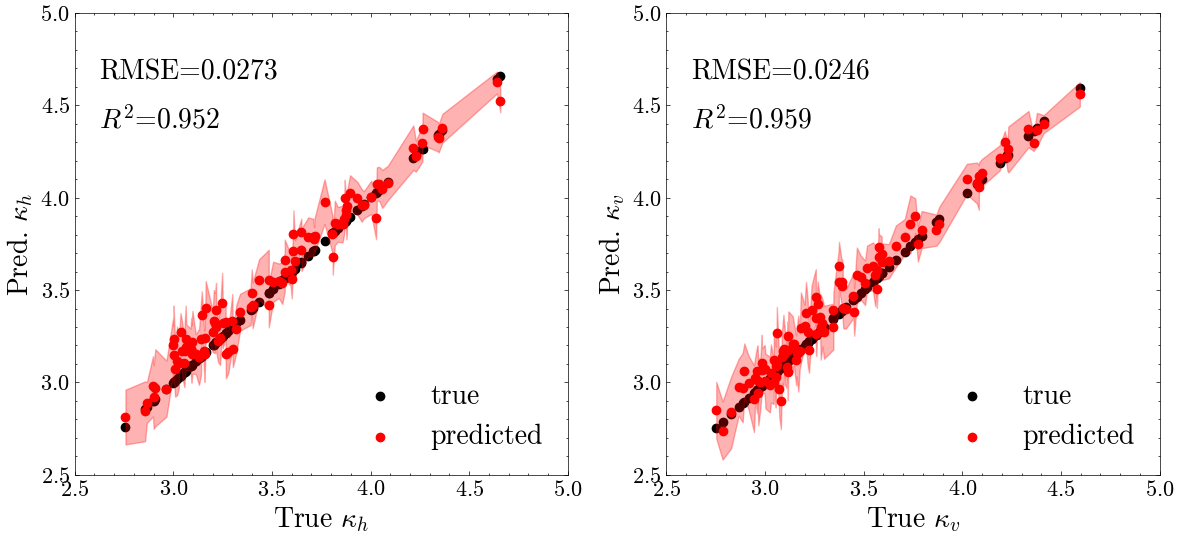

In [3]:
def a_sample(a_prob, samples):
    '''
    a_prob: size(n_batch, mesh_size)
    '''
    a_list = []
    for i in range(samples):
        eps, a_sample = torch.rand_like(a_prob), torch.zeros_like(a_prob)
        #######################
        a_sample = torch.log(eps) - torch.log(1-eps) + torch.log(a_prob+1e-10) - torch.log(1-a_prob+1e-10)
        a_sample[a_sample>0]=mu[0]; a_sample[a_sample<0]=mu[1];
        #######################
        a_list.append(a_sample.unsqueeze(0))
    #
    a = torch.vstack(a_list)
    return a.detach().cpu()

#####################################
feat_test, a_test, ux_test, duxx_test, uy_test, duyy_test, gridx, cd_test = get_data(data_test, 100, dtype)
n_sample = 36
n_test = a_test.shape[0]
dx, dy = 1/(res_sol-1), 1/(res_sol-1)
#
def ux_sample(x, feat, a_check=a_test.reshape(-1, res_sol, res_sol)):
    ''' '''
    with torch.no_grad():
        beta = model_trained['enc'](normalizer_feat.encode(feat.to(device)))
        #
        a_prop = nn.Sigmoid()(model_trained['a'](x.to(device), beta))
        a_pred = a_sample(a_prop, n_sample)
        a_res = a_pred.reshape(n_sample, n_test, res_sol, res_sol)
        ###################################
        ux_pred = model_trained['ux'](x.to(device), beta)
        ux_pred_mean = mollifer_x()(ux_pred, x.to(device)).reshape(-1, res_sol, res_sol).detach().cpu()
        ux_pred_list = []
        noise_list = torch.normal(0., std=0.5*torch.ones((n_sample, n_test, 64*64)))
        for noise in noise_list:
            ux_pred_noise = mollifer_x()(ux_pred + noise, x.to(device)).reshape(-1, res_sol, res_sol).detach().cpu()
            ux_pred_list.append(ux_pred_noise.unsqueeze(0))
        ux_pred = torch.vstack(ux_pred_list)
        # size (200, res_sol, res_sol-2)
        duxx_pred = (ux_pred[...,2:]-ux_pred[...,:-2]) / (2. * dx)
        # flux: (200, res_sol, res_sol-2)
        flux = duxx_pred * a_res[...,:,1:-1]
        #
        cd = torch.mean(flux.reshape(n_sample, n_test,-1), dim=-1)-0.05
        cd_mean, cd_var = torch.mean(cd, dim=0), torch.std(cd, dim=0)
    
    return ux_pred_mean.reshape(n_test,-1,1), a_pred, cd_mean, cd_var
#
def uy_sample(x, feat, a_check=a_test.reshape(-1, res_sol, res_sol)):
    ''' '''
    with torch.no_grad():
        beta = model_trained['enc'](normalizer_feat.encode(feat.to(device)))
        #
        a_prop = nn.Sigmoid()(model_trained['a'](x.to(device), beta))
        a_pred = a_sample(a_prop, n_sample)
        a_res = a_pred.reshape(n_sample, n_test, res_sol, res_sol)
        ###################################
        uy_pred = model_trained['uy'](x.to(device), beta)
        uy_pred_mean = mollifer_y()(uy_pred, x.to(device)).reshape(-1, res_sol, res_sol).detach().cpu()
        # size (200, res_sol, res_sol)
        uy_pred_list = []
        noise_list = torch.normal(0., std=0.5*torch.ones((n_sample, n_test, 64*64)))
        for noise in noise_list:
            uy_pred_noise = mollifer_y()(uy_pred + noise, x.to(device)).reshape(-1, res_sol, res_sol).detach().cpu()
            uy_pred_list.append(uy_pred_noise.unsqueeze(0))
        uy_pred = torch.vstack(uy_pred_list)
        # size (200, res_sol-2, res_sol)
        duyy_pred = (uy_pred[...,2:,:]-uy_pred[...,:-2,:]) / (2. * dy)
        # size (200, res_sol-2, res_sol)
        flux = duyy_pred * a_res[...,1:-1,:]
        #
        cd = torch.mean(flux.reshape(n_sample, n_test,-1), dim=-1)-0.05
        cd_mean, cd_var = torch.mean(cd, dim=0), torch.std(cd, dim=0)

    return uy_pred_mean.reshape(n_test,-1,1), a_pred, cd_mean, cd_var
#
ux_pred, a_pred, cdx_mean, cdx_std = ux_sample(gridx.repeat((n_test, 1, 1)), feat_test)
uy_pred, a_pred, cdy_mean, cdy_std = uy_sample(gridx.repeat((n_test, 1, 1)), feat_test)
print('The shape of ux_test', ux_test.shape, 'ux_pred:', ux_pred.shape)
print('The shape of uy_test', uy_test.shape, 'uy_pred:', uy_pred.shape)
print('The shape of a_test', a_test.shape, 'a_pred', a_pred.shape)
print('*************************************')
print('The test l2 error ux:', solver.getError(ux_pred, ux_test), 'l2 error uy:', solver.getError(uy_pred, uy_test))
############################################
with plt.style.context(['science', 'no-latex']):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    #
    cdx_true = cd_test[:,0]
    sorted_idx = np.argsort(cdx_true)
    # sorted_idx = [i for i in range(n_test)]
    cdx_sort = cdx_true[sorted_idx]
    cdx_mean_sort = cdx_mean[sorted_idx]
    cdx_std_sort = cdx_std[sorted_idx]
    RMSE = torch.sqrt( torch.sum((cdx_true-cdx_mean)**2)/torch.sum(cdx_true**2) )
    R_square = 1 - torch.sum((cdx_true-cdx_mean)**2)/torch.sum((cdx_true-torch.mean(cdx_true))**2)
    #
    axes[0].scatter(cdx_sort, cdx_sort, color='k', label='true', linewidth=1.)
    axes[0].scatter(cdx_sort, cdx_mean_sort, color='red', label='predicted', linewidth=1.)
    axes[0].fill_between(cdx_sort, cdx_mean_sort-1.96*cdx_std_sort/np.sqrt(n_sample), 
                         cdx_mean_sort+1.96*cdx_std_sort/np.sqrt(n_sample), 
                         color='red', alpha=0.3)
    axes[0].set_xlim(2.5, 5)
    axes[0].set_ylim(2.5, 5)
    axes[0].set_xlabel(r'True $\kappa_h$')
    axes[0].set_ylabel(r'Pred. $\kappa_h$')
    axes[0].text(0.05, 0.9, f'RMSE={RMSE.item():.4f}', transform=axes[0].transAxes, 
                 fontsize=20, verticalalignment='top', horizontalalignment='left')
    axes[0].text(0.05, 0.8, f'$R^2$={R_square.item():.3f}', transform=axes[0].transAxes, 
                 fontsize=20, verticalalignment='top', horizontalalignment='left')
    axes[0].legend(loc='lower right')
    ##########################################
    cdy_true = cd_test[:,1]
    sorted_idx = np.argsort(cdy_true)
    # sorted_idx = [i for i in range(n_test)]
    cdy_sort = cdy_true[sorted_idx]
    cdy_mean_sort = cdy_mean[sorted_idx]
    cdy_std_sort = cdy_std[sorted_idx]
    RMSE = torch.sqrt( torch.sum((cdy_true-cdy_mean)**2)/torch.sum(cdx_true**2) )
    R_square = 1 - torch.sum((cdy_true-cdy_mean)**2)/torch.sum((cdy_true-torch.mean(cdy_true))**2)
    #
    axes[1].scatter(cdy_sort, cdy_sort, color='k', label='true', linewidth=1.)
    axes[1].scatter(cdy_sort, cdy_mean_sort, color='red', label='predicted', linewidth=1.)
    axes[1].fill_between(cdy_sort, cdy_mean_sort-1.96*cdy_std_sort/np.sqrt(n_sample), 
                         cdy_mean_sort+1.96*cdy_std_sort/np.sqrt(n_sample), 
                         color='red', alpha=0.3)
    axes[1].set_xlim(2.5, 5.)
    axes[1].set_ylim(2.5, 5.)
    axes[1].set_xlabel(r'True $\kappa_v$')
    axes[1].set_ylabel(r'Pred. $\kappa_v$')
    axes[1].text(0.05, 0.9, f'RMSE={RMSE.item():.4f}', transform=axes[1].transAxes, 
                 fontsize=20, verticalalignment='top', horizontalalignment='left')
    axes[1].text(0.05, 0.8, f'$R^2$={R_square.item():.3f}', transform=axes[1].transAxes, 
                 fontsize=20, verticalalignment='top', horizontalalignment='left')
    axes[1].legend(loc='lower right')
    #
    # plt.tight_layout()
    plt.show()